<a href="https://colab.research.google.com/github/austinbennysmith/OSOM-ERDDAP/blob/master/Suomi_NPP_VIIRS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install netCDF4
import requests
from netCDF4 import Dataset as NetCDFFile
import matplotlib.pyplot as plt
#add vmin & vmax to these cell codes
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
pd.options.display.max_columns = 25
#Colab requires specific installation of cartopy
!apt-get -qq install python-cartopy python3-cartopy;
!pip uninstall -y shapely;    # cartopy and shapely aren't friends (early 2020)
!pip install shapely --no-binary shapely;
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh
import calendar
import datetime

**Conditionals**

In [ ]:
#the code dealing with datetime here is based on code at this link: https://stackoverflow.com/questions/1060279/iterating-through-a-range-of-dates-in-python
#from google.colab import drive
#drive.mount('/content/gdrive')
import datetime
from datetime import date, timedelta
from datetime import datetime as dt
dates2 = []
#dataset_id = ['erdVH2018chla8day', 'erdVH2018chla1day', 'erdVH2018chlamday', 'erdVH2018k4908day', 'erdVH2018k4901day', 'erdVH2018k490mday', 'erdVH2018par8day', 'erdVH2018par1day', 'erdVH2018parmday', 'erdVH2018pic8day', 'erdVH2018pic1day', 'erdVH2018picmday', 'erdVH2018poc8day', 'erdVH2018poc1day', 'erdVH2018pocmday', 'erdVH2018r6718day', 'erdVH2018r6711day', 'erdVH2018r671mday']
dataset_id = input("What's the dataset ID?")
#images_dir = '/content/gdrive/Shared drives/BFK_BOG/SURF_UG/Benny/Images/Phytoplankton_averages'
#In the future, let's get the start and end dates from the metadata
tres = dataset_id[-4:]
if tres=='8day':
  tt = '8 Day '
  start_date = date(2012, 1, 5)
  end_date = date(2020, 5, 12)
  delta = timedelta(days = 8)
  while start_date<=end_date:
    dates2.append(str(start_date))
    start_date += delta
elif tres=='1day':
  tt = '1 Day '
  start_date = date(2012, 1, 2)
  end_date = date(2020, 6, 8)
  delta = timedelta(days = 1)
  while start_date<=end_date:
    dates2.append(str(start_date))
    start_date += delta
elif tres=='mday':
  tt = 'Monthly '
  start_date = date(2012, 1, 15)
  end_date = date(2020, 4, 15)
  def months_iter(start_month, start_year, end_month, end_year):
    start_date = datetime.date(start_year, start_month, 1)
    end_date = datetime.date(end_year, end_month, 1)
    date = start_date
    while date <= end_date:
        yield (date.month, date.year)
        new_new = str(datetime.date(date.year, date.month, 15))
        dates2.append(new_new)
        days_in_month = calendar.monthrange(date.year, date.month)[1]
        date += datetime.timedelta(days_in_month)
  def months(start_month, start_year, end_month, end_year):
    return tuple(d for d in months_iter(start_month, start_year, end_month, end_year))
  months(1, 2012, 4, 2020)
if 'chla' in dataset_id:
  myvar = 'chla'
  unit = 'mg m^-3'
  title = 'Chlorophyll a '
elif 'k490' in dataset_id:
  myvar = 'k490'
  unit = 'm^-1'
  title = 'K490 '
elif 'par' in dataset_id:
  myvar = 'par'
  unit = 'einstein m^-2 day ^-1'
  title = 'Photosynthetically Available Radiation '
elif 'pic' in dataset_id:
  myvar = 'pic'
  unit = 'mol m^-3'
  title = 'Particulate Inorganic Carbon '
elif 'poc' in dataset_id:
  myvar = 'poc'
  unit = 'mg m^-3'
  title = 'Particulate Organic Carbon '
elif 'r671' in dataset_id:
  myvar = 'r671'
  unit = 'sr^-1'
  title = 'Reflectance at 671 nm '

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
What's the dataset ID?erdVH2018r671mday


In [ ]:
means = []
timearray = []
def make_url():
  for i in dates2:
    url = 'https://pricaimcit.services.brown.edu/erddap/griddap/'+dataset_id+'.nc?'+myvar+'[('+i+'T00:00:00Z):1:('+i+'T00:00:00Z)][(42.25):1:(40.50)][(-72.75):1:(-69.75)]'
    r = requests.get(url, allow_redirects=True)
    open('test.nc', 'wb').write(r.content)
    nc = NetCDFFile('test.nc')
    nc
    lat = nc.variables['latitude'][:]
    lon = nc.variables['longitude'][:]
    time = nc.variables['time'][:]
    mapvar = nc.variables[myvar][:]
    fig = plt.figure(i, figsize = (10, 10))
    ax = plt.axes(projection = ccrs.PlateCarree())
    ax.coastlines(resolution='10m', color = 'red')
    ax.set_extent([287.25, 290.25, 40.5, 42.25])
    myplot = plt.pcolormesh(lon, lat, mapvar[0,:,:], cmap = 'rainbow', vmin = 0, vmax = 20)
    means.append((np.mean(mapvar)))
    timearray.append(dt.fromtimestamp(time))
    plt.title(title+i)
    cbar = plt.colorbar()
    cbar.set_label(unit, rotation=270) 
    plt.show()
    #plt.savefig(f"{images_dir}/Photosynthetically Available Radiation (1 day Composite) "+i+".png")
  plt.plot(timearray, means)
  plt.xlabel('Year')
  plt.ylabel(myvar+'('+unit+')')
  plt.title('Avg. '+title+' ('+tt+')')
  #plt.savefig(f"{images_dir}/"+tt+myvar+" VIIRS.png")
  plt.show()

Seeing whether this shows up on github


**Making a climatology from monthly composite**

[['2012-01-15', '2013-01-15', '2014-01-15', '2015-01-15', '2016-01-15', '2017-01-15', '2018-01-15', '2019-01-15', '2020-01-15'], ['2012-02-15', '2013-02-15', '2014-02-15', '2015-02-15', '2016-02-15', '2017-02-15', '2018-02-15', '2019-02-15', '2020-02-15'], ['2012-03-15', '2013-03-15', '2014-03-15', '2015-03-15', '2016-03-15', '2017-03-15', '2018-03-15', '2019-03-15', '2020-03-15'], ['2012-04-15', '2013-04-15', '2014-04-15', '2015-04-15', '2016-04-15', '2017-04-15', '2018-04-15', '2019-04-15', '2020-04-15'], ['2012-05-15', '2013-05-15', '2014-05-15', '2015-05-15', '2016-05-15', '2017-05-15', '2018-05-15', '2019-05-15'], ['2012-06-15', '2013-06-15', '2014-06-15', '2015-06-15', '2016-06-15', '2017-06-15', '2018-06-15', '2019-06-15'], ['2012-07-15', '2013-07-15', '2014-07-15', '2015-07-15', '2016-07-15', '2017-07-15', '2018-07-15', '2019-07-15'], ['2012-08-15', '2013-08-15', '2014-08-15', '2015-08-15', '2016-08-15', '2017-08-15', '2018-08-15', '2019-08-15'], ['2012-09-15', '2013-09-15', '2

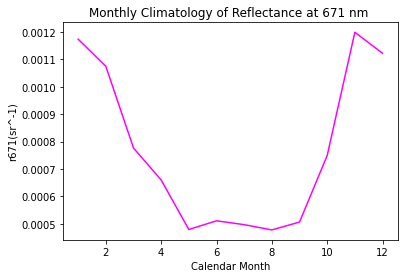

In [ ]:
#the following sets up an array of arrays, with each entry in metarray beimng the set of dates for a given month in the dataset
images_dir = '/content/gdrive/Shared drives/BFK_BOG/SURF_UG/Benny/Images/Phytoplankton_averages/Monthly Climatologies'
metadates = []
metameans = []
months = []
for y in range(1,13):
  months.append(y)
for k in range(1, 13):
  monthdates = []
  for i in dates2:
    datee = dt.strptime(i, "%Y-%m-%d")
    if datee.month == k:
      monthdates.append(i)
  metadates.append(monthdates)
#Next, I need to set up 2 nested for loops. Inner loop iterates though the current entry of metarray, calculates the mean, and adds it to that entry of an array within an array. The outer one iterates through metarray. Then I need a for loop that iterates through the means_metarray, calculates the means for each one, and then I'll graph those means.
print(metadates)
for j in metadates:
  means = []
  for x in metadates[metadates.index(j)]:
    url = 'https://pricaimcit.services.brown.edu/erddap/griddap/'+dataset_id+'.nc?'+myvar+'[('+x+'T00:00:00Z):1:('+x+'T00:00:00Z)][(42.25):1:(40.50)][(-72.75):1:(-69.75)]'
    r = requests.get(url, allow_redirects=True)
    open('test.nc', 'wb').write(r.content)
    nc = NetCDFFile('test.nc')
    nc
    mapvar = nc.variables[myvar][:]
    means.append(np.nanmean(mapvar))
  print(j)
  print(means)
  metameans.append(means)
print(metameans)
finalmeans = []
for z in metameans:
  finalmeans.append(np.nanmean(metameans[metameans.index(z)]))
  print(finalmeans)
plt.plot(months, finalmeans, color = 'magenta')
plt.title('Monthly Climatology of '+title)
plt.xlabel('Calendar Month')
plt.ylabel(myvar+'('+unit+')')
#plt.savefig(f"{images_dir}/"+tt+"Climatology"+myvar+" VIIRS.png")
plt.show()

**Graphing the anomaly**

-7.4949116e-05
-0.0002878615
-0.0001347757
-1.4118152e-05
1.34823495e-05
8.232251e-06
9.336701e-05
7.940474e-05
3.5803823e-05
-3.1812815e-05
0.0005797449
0.00031104102
0.00015790213
0.00074046885
7.5097254e-05
-3.7883292e-05
0.0001399744
0.00021275075
0.00010713609
1.6797683e-05
1.30389235e-05
-7.470831e-05
-3.980589e-06
0.00020142167
0.00021289033
6.489572e-05
-4.082534e-05
0.00014151278
7.440831e-06
-3.4085155e-05
-3.0339637e-05
-9.567922e-05
-4.300775e-05
4.2147585e-06
2.285256e-05
-0.00016014103
8.083612e-05
0.00063116965
-0.00015229604
-0.00021030629
-0.00015250343
-9.015712e-05
-0.000118619006
-7.61275e-05
-7.3467556e-05
4.911184e-05
-0.00020069582
-0.00016838341
0.00017245184
0.0001375872
-8.908071e-05
0.0001009492
0.00011025544
-7.654191e-06
5.377602e-05
6.8556226e-05
4.5294117e-05
-6.6368724e-05
-0.00026417064
-7.536297e-05
-9.977352e-05
-0.00022368797
0.00028860394
4.1017483e-05
0.00011180324
0.00013782491
-2.5293062e-05
7.3905976e-06
7.487665e-05
5.450612e-05
-0.00016883819


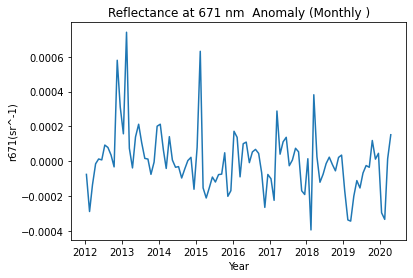

In [ ]:
anomalies = []
means = []
timearray = []
images_dir = '/content/gdrive/Shared drives/BFK_BOG/SURF_UG/Benny/Images/Phytoplankton_averages/Anomalies/VIIRS Anomalies'
def anomaly():
  for i in dates2:
    url = 'https://pricaimcit.services.brown.edu/erddap/griddap/'+dataset_id+'.nc?'+myvar+'[('+i+'T00:00:00Z):1:('+i+'T00:00:00Z)][(42.25):1:(40.50)][(-72.75):1:(-69.75)]'
    r = requests.get(url, allow_redirects=True)
    open('test.nc', 'wb').write(r.content)
    nc = NetCDFFile('test.nc')
    nc
    lat = nc.variables['latitude'][:]
    lon = nc.variables['longitude'][:]
    time = nc.variables['time'][:]
    mapvar = nc.variables[myvar][:]
    index = datetime.datetime.strptime(i, '%Y-%m-%d').month
    addition = np.nanmean(mapvar) - finalmeans[index-1]
    print(addition)
    anomalies.append(addition)
    timearray.append(dt.fromtimestamp(time))
    #in future notebooks, the following conditionals should be done outside of the function:
    #plt.savefig(f"{images_dir}/Photosynthetically Available Radiation (1 day Composite) "+i+".png")
  print(len(anomalies))
  plt.plot(timearray, anomalies)
  plt.xlabel('Year')
  plt.ylabel(myvar+'('+unit+')')
  plt.title(title+' Anomaly ('+tt+')')
  #plt.savefig(f"{images_dir}/"+tt+myvar+" Anomaly VIIRS.png")
  plt.show()
anomaly()